# 1. Introduction

Terrorism. A word that can't be ignored in todays society. Many feel that acts of terrorism have increased drastically the recent years. Often, the attacks on the Twin Towers on the 11th of September 2001 are pointed to as the threshold of this rise in terror. Suspect of the resulting feeling of insecurity are the recent technological advancements. Access to technology has enabled individuals to gain a deeper insight in the reality of terrorist attacks. Shocking footage of violent and inhumane terrorist acts are instantly shared on the web, and attacks are heavily covered by various media sources all over the world.

Conversely, technology enables a more objective approach to terrorism. Attacks are merely data points, viewed from a Big Data perspective, thereby shaking of the emotional load of a particular incident. With this attitude of mind, prejudices can be objectively assessed and proven true or false.

## 1.1. Exploratory questions
* Has the amount of attacks increased during recent years?
* What is the rate of success per region?
* Where do the terrorist attacks take place?
* Which weapon types are popular?

## 1.2. Predictive questions
* Can the success of an attack be predicted by cross-referencing weather conditions?
* Can the number of casualties (killed and wounded) of attacks be predicted from attack-characteristics?


## 1.3. Terrorism criteria
Only data that satisfies the three criteria that define an act of terrorism will be used for analysis.<br>
<br>

**1: POLITICAL, ECONOMIC, RELIGIOUS, OR SOCIAL GOAL**<br>
The violent act must be aimed at attaining a political, economic, religious, or social goal. This criterion is not satisfied in those cases where the perpetrator(s) acted out of a pure profit motive or from an idiosyncratic personal motive unconnected with broader societal change

**2: INTENTION TO COERCE, INTIMIDATE OR PUBLICIZE TO LARGER AUDIENCE(S)**<br>
To satisfy this criterion there must be evidence of an intention to coerce, intimidate, or convey some other message to a larger audience (or audiences) than the immediate victims. Such evidence can include (but is not limited to) the following: pre‐ or post‐attack statements by the perpetrator(s), past behavior by the perpetrators, or the particular nature of the target/victim, weapon, or attack type.

**3: OUTSIDE INTERNATIONAL HUMANITARIAN LAW**<br>
The action is outside the context of legitimate warfare activities, insofar as it targets non‐combatants (i.e. the act must be outside the parameters permitted by international humanitarian law as reflected in the Additional Protocol to the Geneva Conventions of 12 August 1949 and elsewhere).

# 2. Data preparation

## 2.1. Import libraries and load database
Libraries that are neccesary for plotting analytics and prediction are imported. Global Terrorism Database is loaded.

In [1]:
import numpy as np
import pandas as pd


# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns

# Prediction
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import itertools

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier # Validation

# Data prepping
from sklearn.preprocessing import LabelEncoder

print("Libraries imported.")

Libraries imported.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('../input/gtd/globalterrorismdb_0617dist.csv', encoding='ISO-8859-1')
print("Data loaded.")

Data loaded.


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2.2. Data selection and description
The main characteristics of the dataset with respect to the research questions are researched in the exploratory data analysis. These characteristics, for instance trends, potential causality or correlation found, will be used to predict future events.
For a more detailed description of the variables, consult [the codebook](http://start.umd.edu/gtd/downloads/Codebook.pdf).

In [3]:
data_columns = [
    
    'eventid', # Unique ID for a row. No analytic or predictive power, but used in some plotting functions.
    
    # ===== Spatio-Temporal Variables =====
    # The names of these variables speak for themselves;
    # where in time and space was the act of terrorism committed?
                'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
    # ===== Binary Variables (1 -> yes or 0 -> no) ===== 
                'extended', # Did the duration of the incident extend 24 hours?
                'vicinity', # Did the incident occur in the immediate vicinity of the city? Is 0 for IN city.
                'crit1', 'crit2', 'crit3', # The incident meets the criterion (1, 2, 3), described in the introduction.
                'doubtterr', # Is there doubt to wether the attack is an act of terrorism?
                'multiple', # Is this incident connected to other incident(s)? !! Consistently available since 1997 !!
                'success', # Has the attack reached its goal? Depends on type of attack.
                'suicide', # Did the perpetrator intend to escape alive?
                'claimed', # Was the attack claimed by an organised group?
                'property', # Is there evidence of property damage from the incident?
                'ishostkid', # Were there victims taken hostage or kidnapped?
    
    # ===== Continuous Variables =====
                'nkill', # Amount of confirmed kills.
                'nwound', # Amount of confirmed wounded.
    
    # ===== Categorical variables =====
                'country_txt', # Name of country.
                'region', # Region id.
                'region_txt', # Name of region.
                'attacktype1_txt', # Of what type was the attack? I.e. assassination, bombing or kidnapping.
                'targtype1_txt', # What target did the attack have? I.e. business, government or police.
                'natlty1_txt', # Nationality of the target.
                'weaptype1_txt', # What weapon was used?
    
    # ===== Descriptive Variables =====
                'target1', # Description of specific target, if applicable.
                'gname', # Name of the organized group, if applicable.
                'summary', # Summary of the attack.
    
]

## 2.3. Cleaning the data
Missing data and data that is deviant from its guidelines (such as binary data containing '2') is corrected.

In [4]:
data = data.loc[:, data_columns] # Only keep described columns.

# Random acts of violence and other outliers should not be part of the data.
# Thus, restrict the set the only attacks where the terrorism motive is certain.
data = data[(data.crit1 == 1) & (data.crit2 == 1) & (data.crit3 == 1) & (data.doubtterr == 0)]

# Weapontype column contains very long name for vehicle property -> shorten.
data.weaptype1_txt.replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
    'Vehicle', inplace = True)

# Replace -9 (unknown) values with 0 (no). -9 values are much more likely to be false than true.
data.iloc[:,[6, 15, 16, 17]] = data.iloc[:,[6, 15, 16, 17]].replace(-9,0)

# Some values in the claimed category are 2 (should be 0 or 1).
# Assume these were input mistakes and set 2 to 1.
data.claimed.replace(2,1, inplace = True)

# Ensure consistent values and make everything lowercase.
data.target1 = data.target1.str.lower()
data.gname = data.gname.str.lower()
data.summary = data.summary.str.lower()    
data.target1 = data.target1.fillna('unknown').replace('unk','unknown')

# Some nwound and nkill are NaN. Replace them with median.
data.nkill = np.round(data.nkill.fillna(data.nkill.median())).astype(int) 
data.nwound = np.round(data.nwound.fillna(data.nwound.median())).astype(int) 

# Database only reports victims as nkill and nwound. Combine these into ncasualties column.
# Also add has_casualties column.
data['ncasualties'] = data['nkill'] + data['nwound']
data['has_casualties'] = data['ncasualties'].apply(lambda x: 0 if x == 0 else 1)

print("Data cleaned and prepared.")

Data cleaned and prepared.


# 3. Data exploration

## 3.1. Has the amount of attacks increased during recent years?

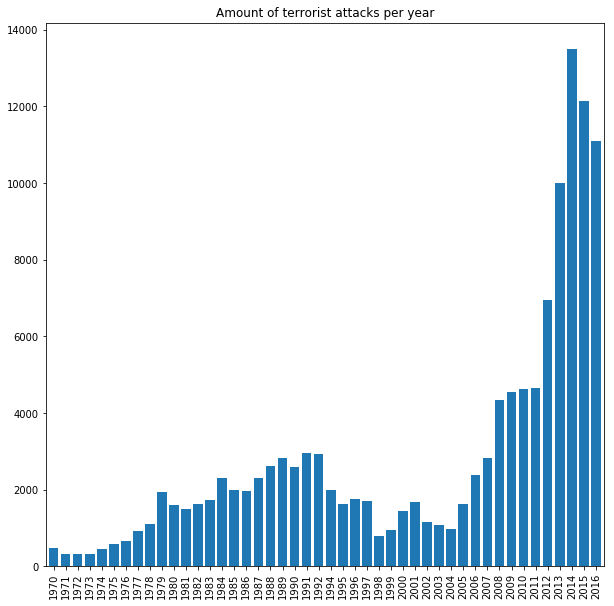

In [5]:
barplot = pd.value_counts(data['iyear'])\
.sort_index()\
.plot\
.bar(width=0.8, figsize=(10, 10), title="Amount of terrorist attacks per year")

By looking at the graph, one might come to the shocking conclusion that the amount of terrorist attacks has been drastically increasing during the last five years. However, it is important to take into account the effictiveness of data collection since 2012.

To quote Michael Jensen, START, November 25, 2013: "*While there is no simple answer to this question, what is certain is that by the start of the 2012 collection effort, the staff working on the GTD had become better than ever at identifying terrorist attacks, regardless of where they happened to occur.*"

This implies that the uncertainty in data collection may or may not be responsible for the increase in attacks. The same [article](http://www.start.umd.edu/news/discussion-point-benefits-and-drawbacks-methodological-advancements-data-collection-and-coding)  puts this statement into perspective:  “With that said, the GTD team believes that some portion of the observable increase in terrorist activity since 2011 is the result of new advancements in collection methodology.” Concluding, results from data analysis should be considered with care.

## 3.2. What is the rate of success of attacks per region?

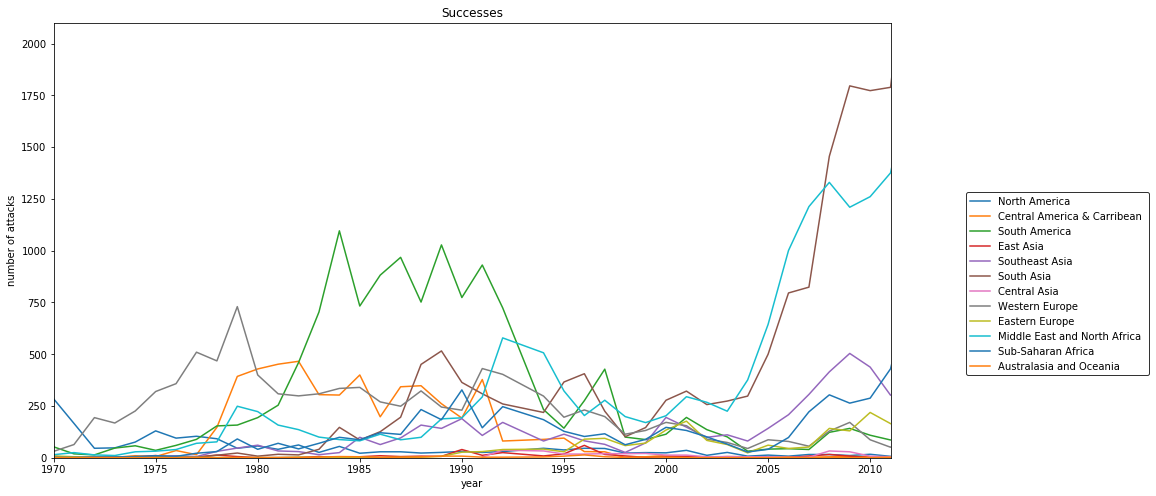

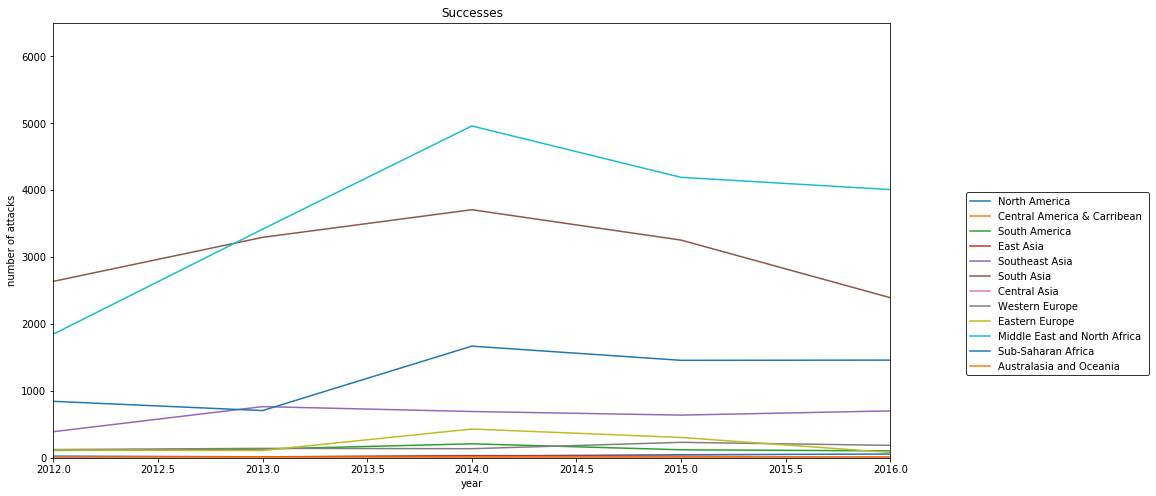

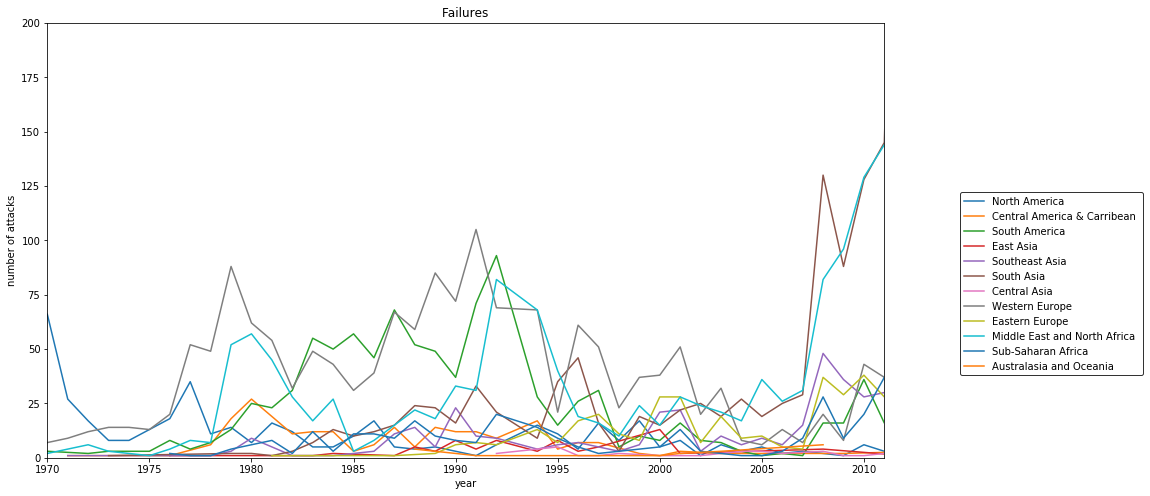

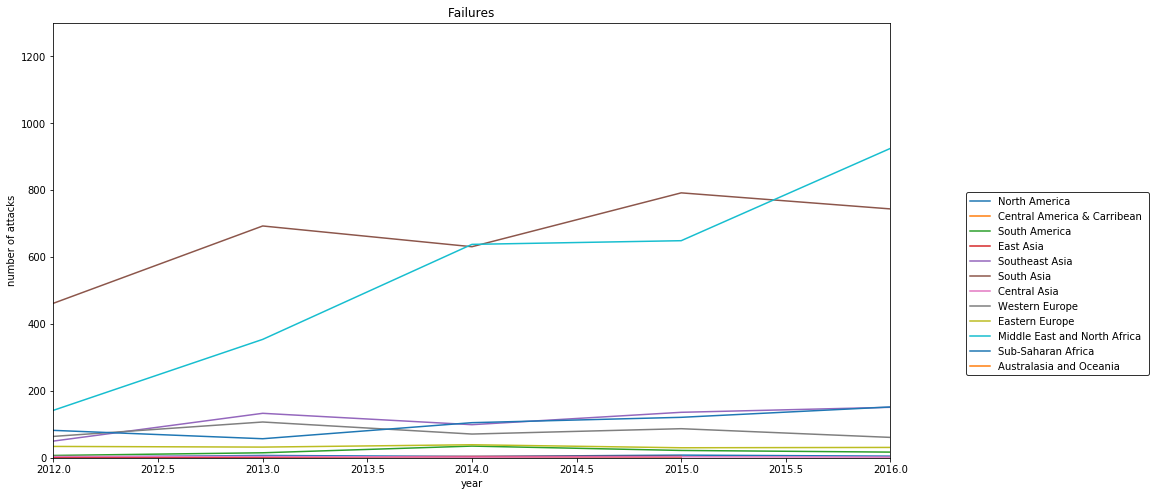

In [6]:
region_dictionary = {1: 'North America', 2: 'Central America & Carribean', 3: 'South America',
                     4: 'East Asia', 5: 'Southeast Asia', 6: 'South Asia', 7: 'Central Asia',
                     8: 'Western Europe', 9: 'Eastern Europe', 10: 'Middle East and North Africa',
                     11: 'Sub-Saharan Africa', 12: 'Australasia and Oceania'}

def multi_graph(result,result_list, xmin, xmax, ymin, ymax):
    fig2, ax2 = plt.subplots(figsize = (15,8))
    number = 1 #the for-loop in append_list processes the regions in order from 1 to 12
    for j in result_list:
        ax2.plot(j.index, j.eventid, label = '%s ' % region_dictionary[number] )
        number += 1

    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('year')
    plt.ylabel('number of attacks')
    plt.title(result)
    ax2.legend(loc = 'center', frameon = True, edgecolor = 'black',bbox_to_anchor =(1.2,0.4))


success_list = []
failure_list = []

for i in region_dictionary:
    region_data = data[(data.region == i)]
    region_data_success = region_data[(region_data.success == 1)]
    region_data_failure = region_data[(region_data.success == 0)]
    region_grouped_success = region_data_success.groupby('iyear').count()
    region_grouped_failure = region_data_failure.groupby('iyear').count()

    
    success_list.append(region_grouped_success)
    failure_list.append(region_grouped_failure)

multi_graph('Successes',success_list, 1970, 2011, 0, 2100)
multi_graph('Successes',success_list, 2012, 2016, 0, 6500)
multi_graph('Failures',failure_list, 1970, 2011, 0, 200)
multi_graph('Failures',failure_list, 2012, 2016, 0, 1300)

Immediately noticable is the drop in both successfull and failed attacks in 1998. This is a phenomon shared by all regions and should be investigated more closely. During the last 5 years (2011-2016) there is no clear increase in attacks except for North America and in some extend also South-Asia. The strong increase of failed attacks in North America could by through the sharpened measures taken after 9/11 2001. At the same time the number of successful attacks increased too and is declining since 2014 for both North America and South Asia.

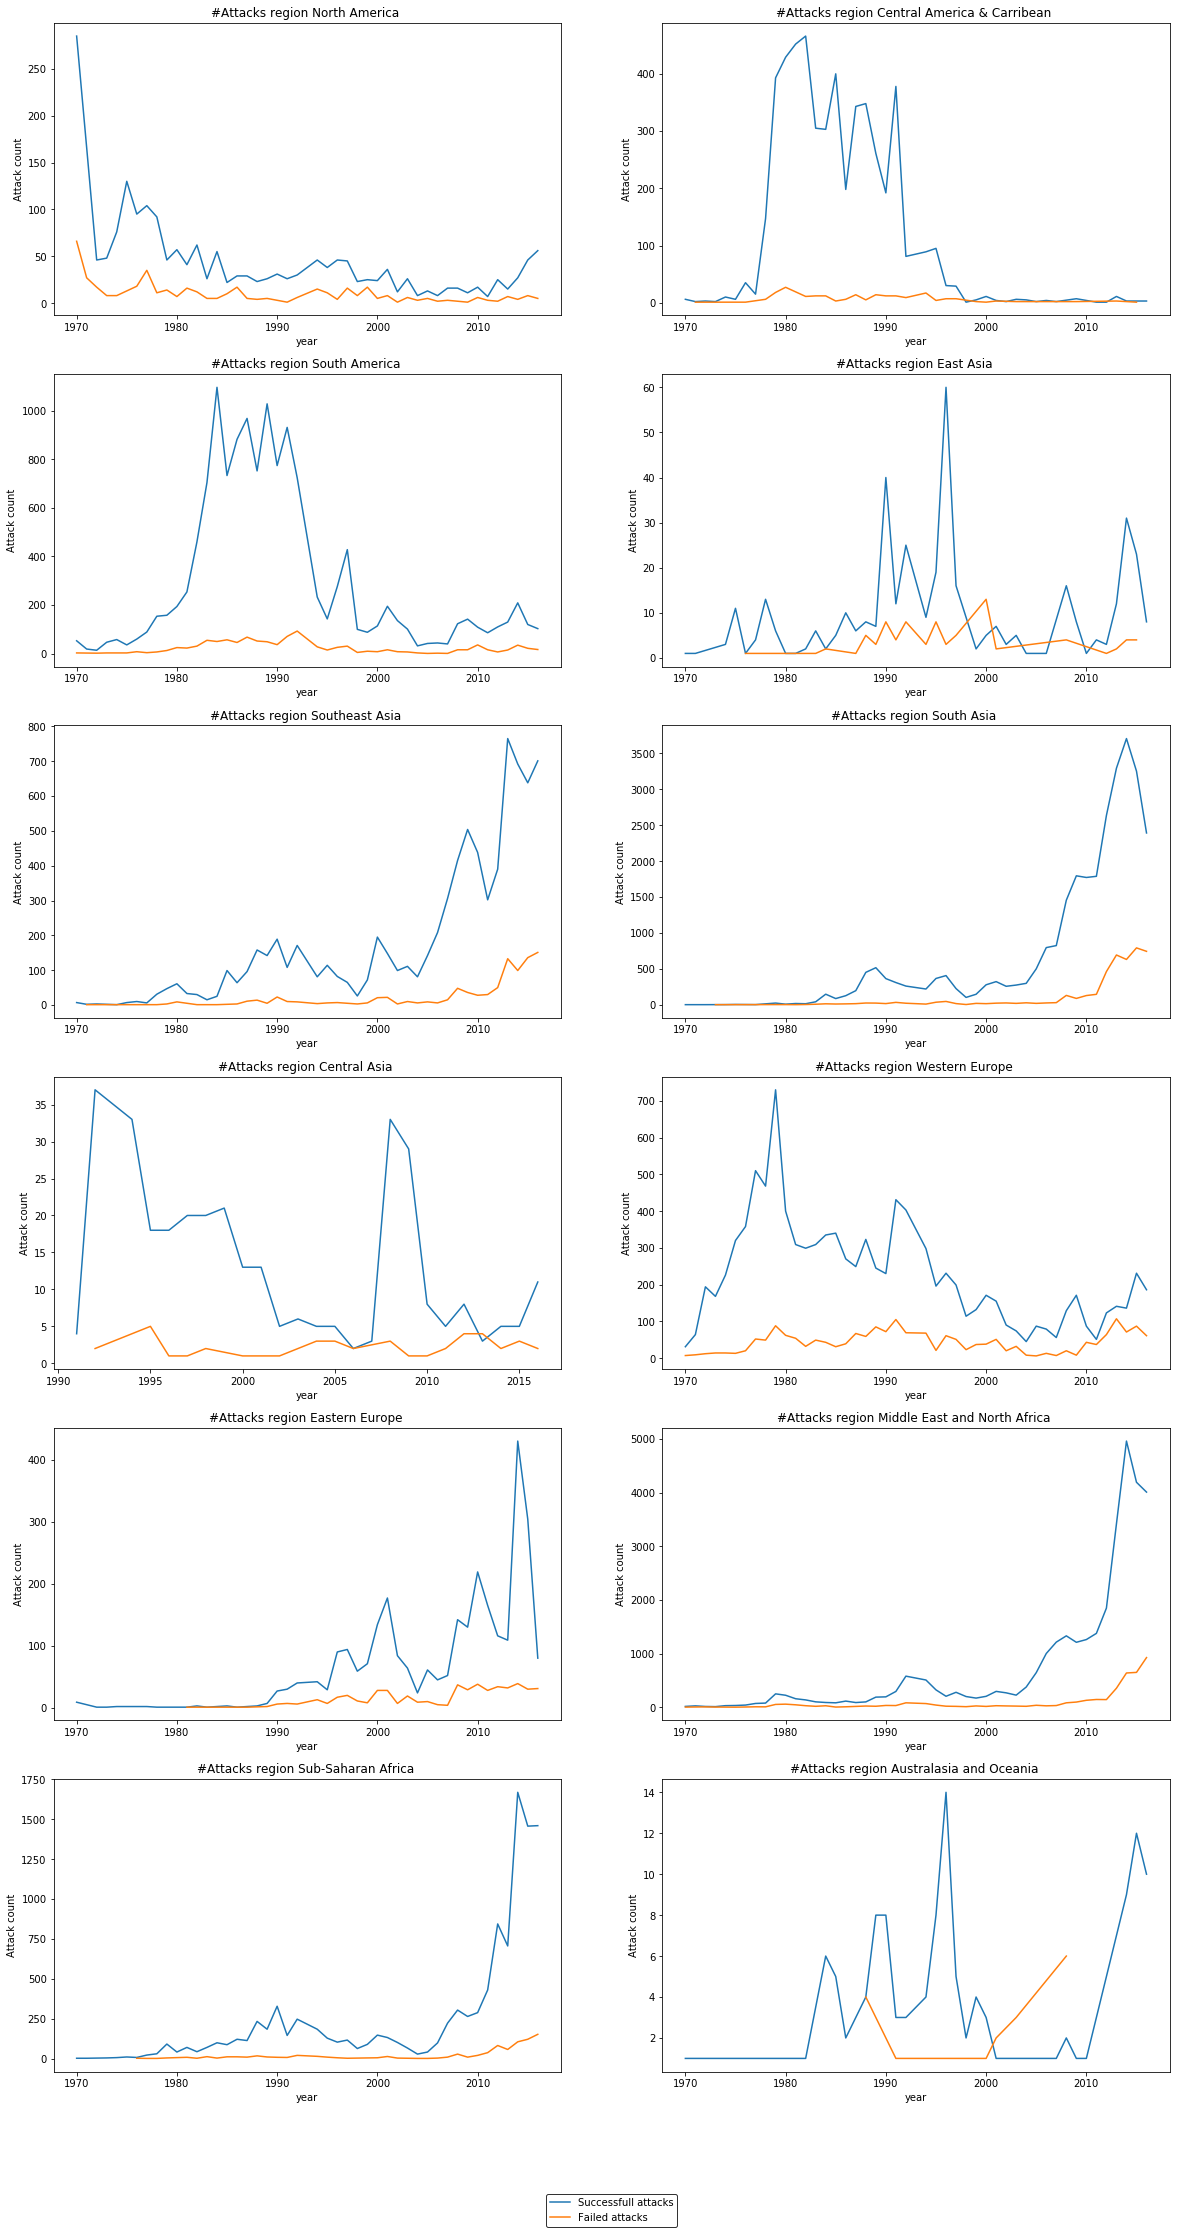

In [7]:
def generate_graph(by_region_list):
    fig = plt.figure(figsize=(20,70))
    i = 1
    
    for element in by_region_list:
        ax1 = fig.add_subplot(11,2,i)
        ax1.set(title = '#Attacks region %s ' % region_dictionary[element[2]],
                ylabel = 'Attack count', xlabel = 'year')

        #entering data
        ax1.plot(element[0].index, element[0].eventid, label = 'Successfull attacks' )
        ax1.plot(element[1].index, element[1].eventid, label = 'Failed attacks' )
        
        i+=1
    
    #add legend
    ax1.legend(loc = 'upper center', frameon = True, edgecolor = 'black', bbox_to_anchor =(-0.1,-0.4))
    plt.show()  


def by_region():
        for region_number in region_dictionary:
            region_data = data[(data.region == region_number)] #for each region group data by year
            region_grouped_success = region_data[(region_data.success == 1)].groupby('iyear').count() #filter on success and group by year
            region_grouped_failure = region_data[(region_data.success == 0)].groupby('iyear').count() #filter on failure and group by year
            
            by_region_list.append([region_grouped_success, region_grouped_failure, region_number])
        
        #create line plot for region grouped by year
        generate_graph(by_region_list)

by_region_list = []
by_region()

The graphs show no clear trend through time, they show erratic lines. There are some, such parts of Asia and Africa, that display strong increase from about 2005. The question is if this is a consequence of better documentation and communication or that the number of attacks indeed have increased.

## 3.3. Where do the terrorist attacks take place?

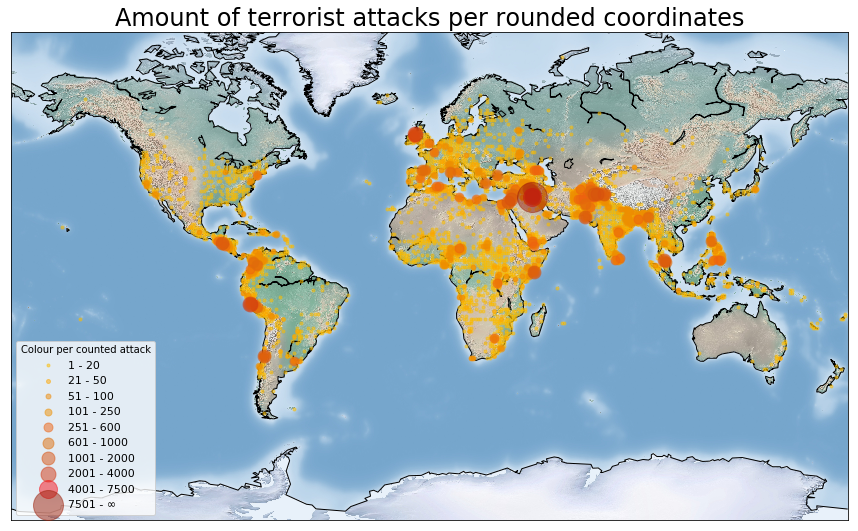

In [8]:
orange_palette = ((3, 0, '#FBBC00', '1 - 20'), (4, 20, '#FDA600', '21 - 50'), (5, 50, '#EE8904', '51 - 100'), \
                  (7, 100, '#ED9001', '101 - 250'), (9, 250, '#ED6210', '251 - 600'), \
                  (11, 600, '#DE6D0A', '601 - 1000'), (13, 1000, '#D8510F', '1001 - 2000'), \
                  (15, 2000, '#D23711', '2001 - 4000'), (18, 4000, '#F61119', '4001 - 7500'), \
                  (30, 7500, '#9C200A', '7501 - ∞')) #marker size, count size, color

plt.figure(figsize=(15,15))
# Rounds the long- and latitude to a number withouth decimals, groups them on long- and latitude and counts the amount of attacks.
df_coords = data.round({'longitude':0, 'latitude':0}).groupby(["longitude", "latitude"]).size().to_frame(name = 'count').reset_index()
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.shadedrelief()
    
def plot_points(marker_size, count_size, colour, label_count):
    x, y = m(list(df_coords.longitude[df_coords['count'] >= count_size].astype("float")),\
                (list(df_coords.latitude[df_coords['count'] >= count_size].astype("float"))))
    points = m.plot(x, y, "o", markersize = marker_size, color = colour, label = label_count, alpha = .5)

for p in orange_palette:
    plot_points(p[0], p[1], p[2], p[3]) 
    
plt.title("Amount of terrorist attacks per rounded coordinates", fontsize=24)
plt.legend(title= 'Colour per counted attack', loc ='lower left', prop= {'size':11})
plt.show()

Text(0.5,1,'Amount of terrorist attacks per rounded coordinates')

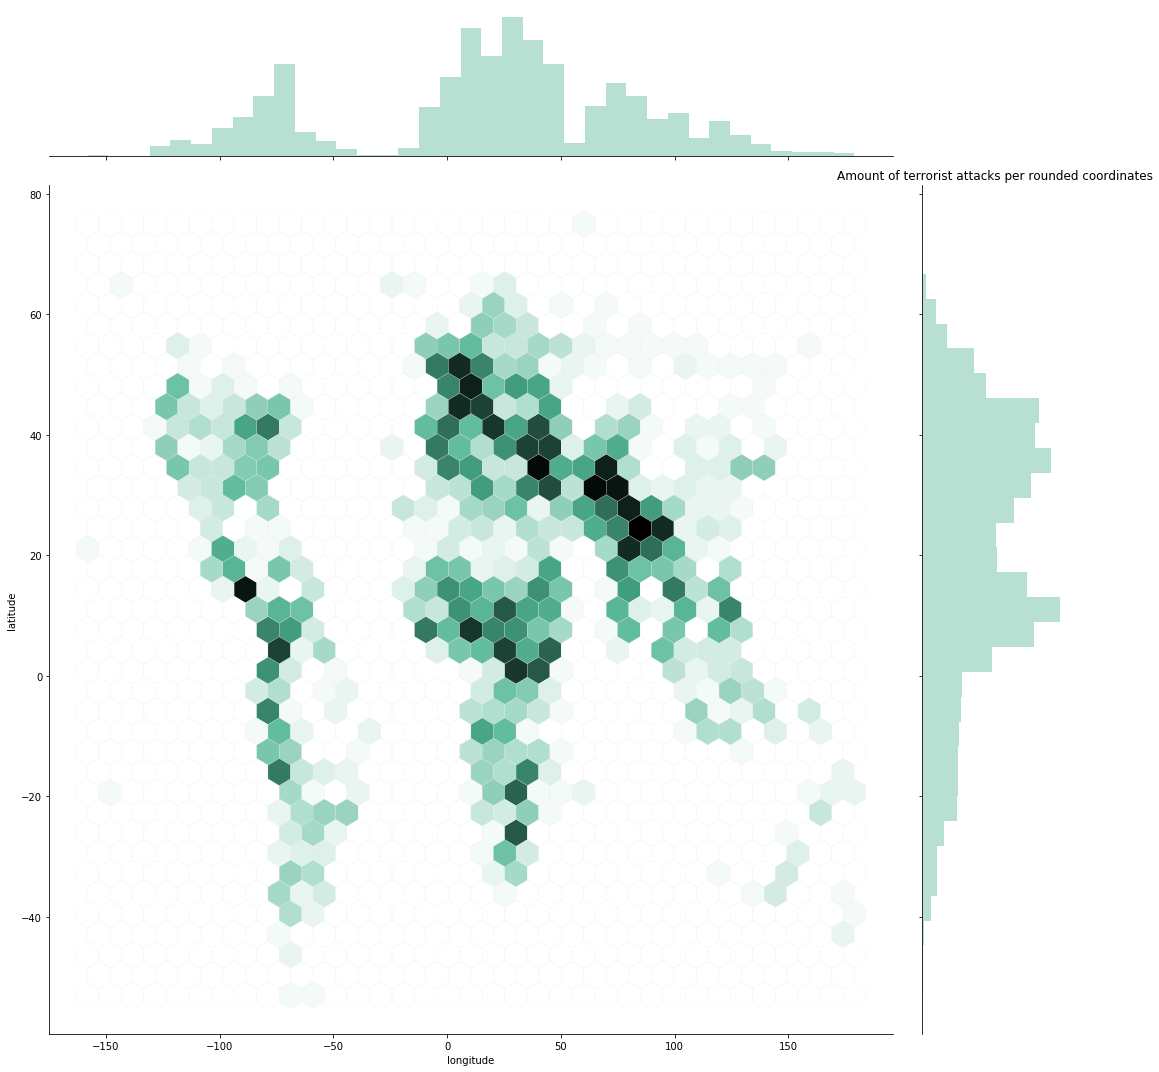

In [9]:
sns.jointplot(x='longitude', y='latitude', data=df_coords, kind="hex", color="#4CB391", size=15, stat_func=None, edgecolor="#EAEAF2", linewidth=.2)
plt.title('Amount of terrorist attacks per rounded coordinates')

The images above show where the documented attacks are concentrated. The worldmap gives a more clear view on where in the world there are more attacks, the hexagram-representation substanciates that and add barcharts for both longitude and latitude to infer attack-intensity.

The worldmap shows which countries are most troubled by terrorism. From the map the conclusion can be drawn that the Middle East is most troubled by terrorism. The countries in the Middle East that are often affected by terrorism are Iraq, Iran and Syria. Some other countries that heavily suffered over the years from terrorism are India, Pakistan and Ireland.

The hexplot shows for which range longitude and latitude the attacks are most common. For longitude it is mainly between 5 and 40 and for latitude it is around 35 and 12.

## 3.4. Which attack types are popular?

Text(0,0.5,'Attack type')

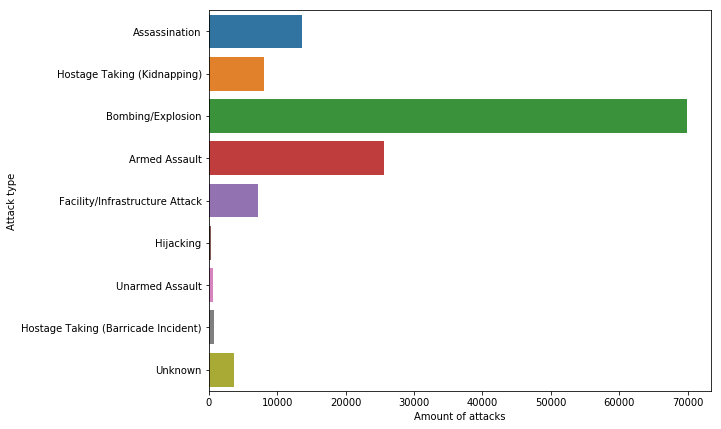

In [10]:
plt.figure(figsize=(9,7))
ax = sns.countplot(y="attacktype1_txt", data=data)
ax.set_xlabel("Amount of attacks")
ax.set_ylabel("Attack type")

As the graph portrays, Bombing/Explosion is the most popular attacktype by far.

# 4. Predictive analysis

## 4.1. Can the success of an attack be predicted by cross-referencing weather conditions?
A weather database was downloaded and merged in an attempt to see if there is correlation between weather conditions and terrorist attacks. It contains daily snapshots (taken at 12:00 PM) from January 1979 to July 2017 of the following weather conditions all over the world:

* 2 metre temperature
* Total cloud cover
* Vertical integral of divergence of geopotential
* Surface pressure
* 10 metre V wind component

Each row in the terrorist dataset contains a date (iyear, imonth, iday) and coordinates (lat, long). These variables were used to index the 3-dimensional weather data, and the resulting values were appended to the corresponding row in the terrorist dataset. In the end, for a given terrorist attack, the weather at that approximate place could be retrieved. Do note that the time at which an attack was executed, is not recorded in the database. The actual weather at that time might therefore deviate from the recorded weather (at 12:00 PM). Also, as mentioned earlier, the weather location is an approximation of the precise attack location, as the weather coordinates follow steps of 0.75, whereas the terrorist locations are more precise.

The script used to merge the databases can be found via this link: https://github.com/DaanSterk/merge_terrorism_weather/blob/master/merge.py.

In [11]:
# Load the dataset.
data_w = pd.read_csv('../input/terrorist-weather/terrorist_weather_jan2012_dec_2016.csv', encoding='ISO-8859-1')

In [12]:
# This set has the same columns as the original dataset and has been cleaned in the same manner.
# Additionally, five weather condition columns were added, as described above.
data_w.head()

,iyear,imonth,iday,latitude,longitude,extended,vicinity,crit1,crit2,crit3,...,target1,gname,summary,ncasualties,has_casualties,t2m,tcc,vidgf,sp,v10
0,2012,1,1,30.209423,67.018009,0,0,1,1,1,...,paan shop,unknown,01/01/2012: a grenade was thrown into a shop o...,12,1,288.217098,9.998669e-13,-366.496179,101457.723797,-3.828428
1,2012,1,1,-0.456120,39.646123,0,0,1,1,1,...,bar,al-shabaab,01/01/2012: assailants threw two grenades and ...,17,1,297.077670,1.530221e-01,606.077234,101103.215653,1.320113
2,2012,1,1,-0.456120,39.646123,0,0,1,1,1,...,bar,al-shabaab,01/01/2012: assailants threw a grenade and ope...,16,1,297.077670,1.530221e-01,606.077234,101103.215653,1.320113
3,2012,1,1,28.466667,67.283333,1,0,1,1,1,...,civilians,unknown,01/01/2012: four men were kidnapped from their...,0,0,287.513173,9.998669e-13,-17.655798,100755.508624,-3.728933
4,2012,1,1,34.761723,71.324719,0,0,1,1,1,...,militia members,unknown,01/01/2012: an explosive device targeting anti...,4,1,269.929184,9.998669e-13,62.722170,79226.577609,0.577216


In [13]:
# Define X and y.
X = data_w[['t2m', 'tcc', 'vidgf', 'sp', 'v10']].fillna(0) # Features
y = data_w['has_casualties'].fillna(0) # Target

X.shape, y.shape

((53715, 5), (53715,))

In [14]:
# Count the number of attacks that have at least 1 casualty and those that don't.
y.value_counts()

1    36396
0    17319
Name: has_casualties, dtype: int64

In [15]:
# Split into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Use SVM as classifier.
model = svm.SVC()

# Fit the model with training sets.
%time model.fit(X_train, y_train)

# Predict wether there are casualties or not.
%time y_pred = model.predict(X_test)

CPU times: user 2min 9s, sys: 12 ms, total: 2min 9s
Wall time: 2min 9s
CPU times: user 12.3 s, sys: 0 ns, total: 12.3 s
Wall time: 12.3 s


In [16]:
np.mean(y_pred == y_test)

0.73223704623022035

Support Vector Machine performed best of all classification algorithms that were tried. To find out, a dummy classifier is introduced to predict the most frequent label in the dataset.

In [17]:
# Simply predict the most frequent value every time.
# This determines the baseline accuracy.
model = DummyClassifier(strategy="most_frequent")

%time model.fit(X_train, y_train)

%time y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.75 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 227 µs


0.67911883338504497

Support Vector Machine produces an accuracy of 73,5% versus the dummy classifier of 68%. There seems to be some, albeit minimal predictive power in the weather conditions.

## 4.2. Can casualties be predicted from GTD-exclusive features?
Now, columns that are exclusively part of the Global Terrorism Database will be tested for their significance on predicting casualties.

In [18]:
feature_cols = [
    'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
                'extended',
                'vicinity',
                'doubtterr',
                'multiple',
                'success',
                'suicide',
                'claimed',
                'property',
                'ishostkid',
    
                'country_txt',
                'region',
                'attacktype1_txt',
                'targtype1_txt',
                'weaptype1_txt',
]

# Target is a binary value: were there any casualties in the attack?
target_col = 'has_casualties'

lb = LabelEncoder()
data['country_txt'] = lb.fit_transform(data['country_txt'])
data['attacktype1_txt'] = lb.fit_transform(data['attacktype1_txt'])
data['targtype1_txt'] = lb.fit_transform(data['targtype1_txt'])
data['weaptype1_txt'] = lb.fit_transform(data['weaptype1_txt'])

# Define X and Y.
X = data[feature_cols].fillna(0)
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

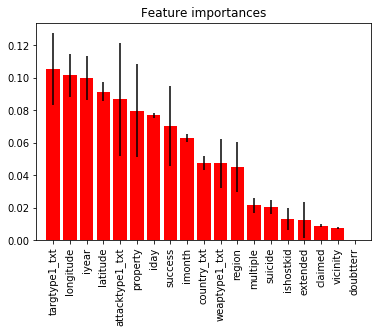

In [19]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
fnames = [feature_cols[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), fnames, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

This plot shows the significance of each feature on predicting wether there will be casualties or not. Spatio temporal variables seem to be very dominantly present. However, time variables (iyear, imonth, iday) are not appropriate to keep, because predictions into the future will supply the model with meaningless values (the model never saw year values > 2017 before). Furthermore, to avoid overfitting the model, only features with an accuracy score of 0.05 and higher are kept.

In [20]:
feature_cols = ['longitude', 'targtype1_txt', 'latitude', 'attacktype1_txt', 'success', 'property', 'country_txt', 'weaptype1_txt', 'region']

X = data[feature_cols].fillna(0) # Assign chosen features to X.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
model = RandomForestClassifier(n_estimators=20)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

0.83146470995715427

Confusion matrix, without normalization
[[13012  3182]
 [ 3387 19396]]
Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.15  0.85]]


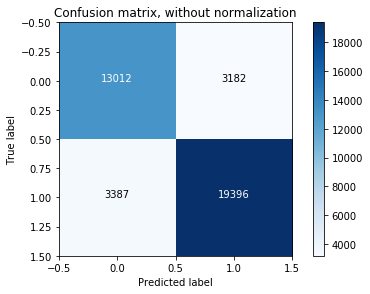

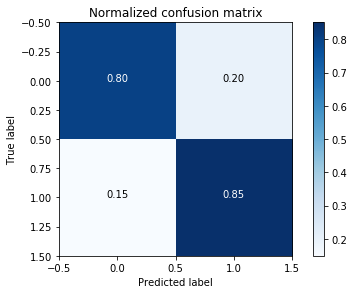

In [22]:
cnf_matrix = confusion_matrix(y_test, y_pred)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()

In [23]:
# Better validation with K-fold.
model = RandomForestClassifier(n_estimators=20)

scores = cross_val_score(model, X, y, cv=10) # Ten-fold cross validation.
print(scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[ 0.73  0.74  0.72  0.8   0.77  0.76  0.8   0.78  0.78  0.8 ]
Accuracy: 0.77 (+/- 0.05)


In [24]:
# Simply predict the most frequent value every time.
# This determines the baseline accuracy.
model = DummyClassifier(strategy="most_frequent")

%time model.fit(X_train, y_train)

%time y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.35 ms
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 1.29 ms


0.58452420658336968

Supplied with the chosen features, the Random Forest classifier achieves an accuracy score of 0.77. The baseline accuracy is 0.58.

# 5. Conclusion


## 5.1. Challenges with external databases
A question that arose early in the exploratory stage of the project was: do environmental factors affect the timing of a terrorist attack? More specifically, do perpetrators consiously or unconsiously take into account weather conditions in some way? Initially this theory was rejected because there were no indications of a higher chance of an attack in some specific month of the year.

To more formally test the predictive power of weather conditions, an external global weather database was downloaded and terrorism records were appended with the weather conditions of that particular day. Using Support Vector Machine, some predictive power was proven to exist. Although this was minimal, it was still a surprising finding since the nature of the weather database resulted in some inaccuracies while merging. Properties of the weather database that contributed to these inaccuracies were:

**Rounded coordinates**<br>
The coordinates in the terrorism database were more precise than those of the weather database. Hence the coordinates were rounded to the nearest corresponding coordinate. This could mean a maximum difference of 0.375 degrees, or approximately 55 kilometers latitude and longitude.

**Weather timestamp**<br>
For the time of day, the problem was the other way around; the weather database timestamps were accurate to three hours at any given day, whereas the terrorism database only covered the date, so no indication of clock time at all. Therefore the weather at 12:00PM was taken.

Would these imprecisions not be there, the accuracy of the prediction would presumably be much greater. Working with merged data was a very informative experience, because it emphasized that the degree of compatibility of two databases determines, or at least heavily influences the final prediction accuracy.  


## 5.2. Prediction of casualties
To continue the predictive part of the research, the importance of each column of the terrorism database was estimated using the Random Forest classifier. The resuts were plotted in a bar graph, ordered by accuracy. Time variables such as day, month and year were excluded from features, despite proving to possess high predictive power.

Finally, the best features were chosen and collectively used in a Random Forest classifier. The features included:
* Longitude
* Target type,
* Latitude
* Attack type
* Success
* Property (damage)
* Country

The Random Forest classifier produced an accuracy score of 78%.